In [9]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Download the MNIST dataset
train_ds = torchvision.datasets.MNIST(root="./datasets",download=True,train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST(root="./datasets",download=True,train=False,transform=torchvision.transforms.ToTensor())

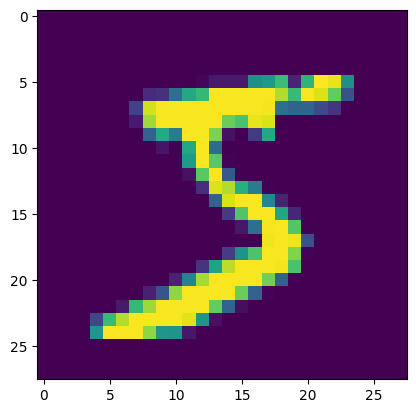

In [3]:
# Sample image in the MNIST dataset
plt.imshow(train_ds[0][0][0].numpy())

In [4]:
# Create dataloader (batched) of the dataset
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128)

In [5]:
# Define the device to be used
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


In [6]:
# Function to train the neural network model for one epoch (one loop over all items in the train dataset)
def train_one_epoch(model, train_dl, crit,optim):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in train mode
    model.train()
    # Loop over each x,y pair in the batched dataloader
    for x,y in train_dl:
        # Set the gradients of all parameters to zero
        optim.zero_grad()
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
        # Backward (calculate the gradient of loss with respect to each parameter)
        l.backward()
        # Update each parameter using the calculated gradient of the loss
        optim.step()
    return avg_loss / len(train_dl), 100*(corrects/total)

# Function to test the model over all item in the test dataset
def test_model(model, test_dl, crit):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in evaluation mode
    model.eval()
    # Loop over each x,y pair in the batched dataloader
    for x,y in test_dl:
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
    return avg_loss / len(train_dl), 100*(corrects/total)

In [39]:
# Defining the neural network model and send it to the device
# MLP model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,10)
).to(dev)

# Defining the optimizer to be used to train the neural network model
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining our loss function
crit = torch.nn.CrossEntropyLoss()

In [41]:
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")

 20%|█████████████████                                                                    | 1/5 [00:13<00:54, 13.65s/it]

train_loss: 0.7270853052706098, train_acc: 79.2683334350586, test_loss: 0.05591209168468457, test_acc: 89.75


 40%|██████████████████████████████████                                                   | 2/5 [00:27<00:41, 13.83s/it]

train_loss: 0.2724706802223283, train_acc: 92.12999725341797, test_loss: 0.03923493130668712, test_acc: 93.04000091552734


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:42<00:28, 14.27s/it]

train_loss: 0.20084392184467076, train_acc: 94.16333770751953, test_loss: 0.030851550311890682, test_acc: 94.3499984741211


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:57<00:14, 14.65s/it]

train_loss: 0.15912353551622901, train_acc: 95.3499984741211, test_loss: 0.025251141957827468, test_acc: 95.36000061035156


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.07s/it]

train_loss: 0.13108363200519194, train_acc: 96.19833374023438, test_loss: 0.0216715844707496, test_acc: 96.01000213623047


In [34]:
# If you have saved the model before
model.load_state_dict(torch.load("models/mnist_mlp.ckpt"))

<All keys matched successfully>

prediction = 4, actual = 4


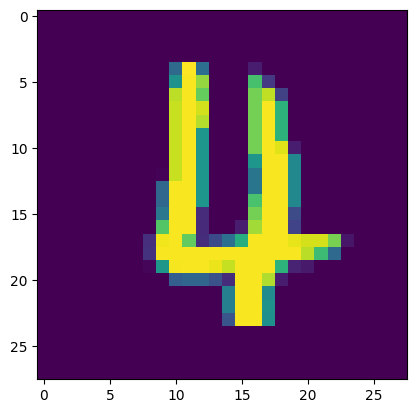

In [38]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,1,28,28)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [14]:
# Saving our model
torch.save(model.state_dict(),"models/mnist_mlp.ckpt")

In [15]:
# Function to create the convolutional layer (conv layer + relu + max pool)
def make_conv_layer(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

In [23]:
# Defining the neural network model and send it to the device
# Convolutional model
model = nn.Sequential(
    make_conv_layer(1,16,7), # in size = 1 x 28 x 28 -> out size  = 16 x 11 x 11
    make_conv_layer(16,32,4), # in size = 16 x 11 x 11 -> out size  = 32 x 4 x 4
    nn.Flatten(),
    nn.Linear(32 * 4 * 4,10)
).to(dev)

# Defining the optimizer to be used to train the neural network model
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining our loss function
crit = torch.nn.CrossEntropyLoss()

In [17]:
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")

 20%|█████████████████                                                                    | 1/5 [00:29<01:56, 29.18s/it]

train_loss: 0.33398880648500184, train_acc: 90.24000549316406, test_loss: 0.022771642710179535, test_acc: 95.43000030517578


 40%|██████████████████████████████████                                                   | 2/5 [00:51<01:14, 24.92s/it]

train_loss: 0.09229282463100483, train_acc: 97.27166748046875, test_loss: 0.013931980263057059, test_acc: 97.19999694824219


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:17<00:51, 25.77s/it]

train_loss: 0.06981775027561758, train_acc: 97.95166778564453, test_loss: 0.011048984657103038, test_acc: 97.79999542236328


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [01:45<00:26, 26.68s/it]

train_loss: 0.058366609223461006, train_acc: 98.26166534423828, test_loss: 0.009460240993161015, test_acc: 98.06999969482422


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.65s/it]

train_loss: 0.05112624575104962, train_acc: 98.50833129882812, test_loss: 0.00849573156833753, test_acc: 98.23999786376953


In [27]:
# If you have saved the model before
model.load_state_dict(torch.load("models/mnist_conv.ckpt"))

<All keys matched successfully>

prediction = 8, actual = 8


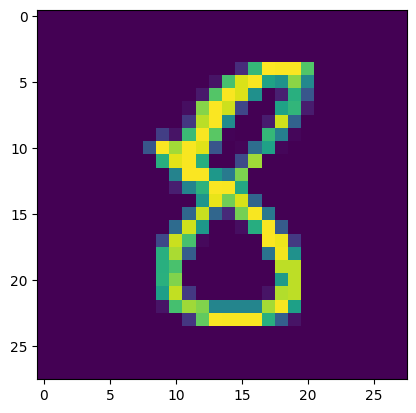

In [32]:
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,1,28,28)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [22]:
# Saving our model
torch.save(model.state_dict(),"models/mnist_conv.ckpt")